**Authors :** Alexandre Sukeratha, Jules Michaud

# Project Econometrics - Part 2
_Important : some cells require the previous cells to be runned to properly function. Therefore, we advise you to press the "Run All" button before taking a look at the NoteBook._

### Importing Librairies

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('darkgrid')

### Importing the Data Set

In [ ]:
df = pd.read_excel('Data/quarterly.xls')
df.head(2)

## Table of contents
_Disclaimer: The following links take you to the end of each respective question._
* [Question 1](#q1)
* [Question 2](#q2)
* [Question 3](#q3)
* [Question 4](#q4)
* [Question 5](#q5)
* [Question 6](#q6)
* [Question 7](#q7)
* [Question 8](#q8)
* [Question 9](#q9)
* [Question 10](#q10)
* [Question 11](#q11)

### 1. Possible problem of missing observations <a class="anchor" id="q1"></a>

In [ ]:
# Dropping NaN values and potential duplicates :
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

### 2. Inflation rate analysis <a class="anchor" id="q2"></a>

We have, 
$$ \text{inf} = \frac{\text{CPI}(t) - \text{CPI}(t-1)}{\text{CPI}(t)}$$

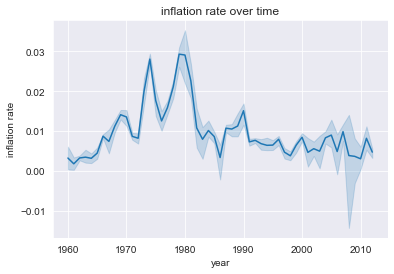

In [ ]:
# Computing the inflation rate :
CPI = df['CPI']
CPI_1 = np.roll(CPI, 1)
CPI_1[0]=CPI[0]

df['inf'] = (CPI-CPI_1)/CPI
df['DATE_yr'] = pd.to_datetime(df['DATE'].str[0:4])

# Plotting the results :
sns.lineplot(x='DATE_yr', y='inf', data=df)
plt.xlabel('year')

plt.ylabel('inflation rate')
plt.title('inflation rate over time')

plt.show()
plt.close()


**Comments :**
The inflation rate peaked in the 1980s (as a result of the great inflation of the 1970s). It then stabilized and fell in 2008 (as a result of the subprime crisis).

### 3. Autocorrelogram and Partial-autocorrelogram of `inf` <a class="anchor" id="q3"></a> 

Difference between the two plots :
* **Autocorrelogram :** Autocorrelation measures the relationship between a variable’s current value and its past values.
* **Partial-autocorrelogram :** it only shows the correlation between two observations that is not explained by the shorter lags between those observations.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


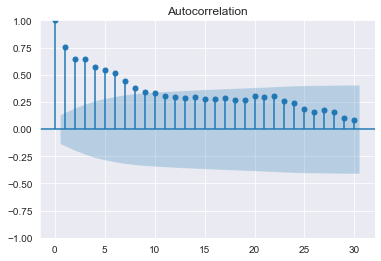

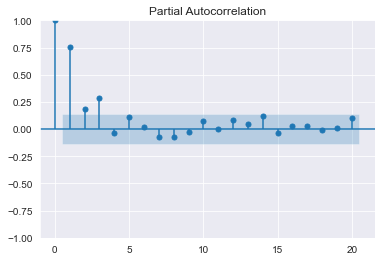

In [ ]:
# Autocorrelation of inf :
sm.graphics.tsa.plot_acf(df['inf'], lags=30);

# Partial autocorrelation of inf :
sm.graphics.tsa.plot_pacf(df['inf'], lags=20);

plt.show()
plt.close()

**Analysis of the two autocorrelograms :**
* The first graph shows that the autocorrelation decreases slowly with time. This reveals the presence of trends in the time series.
* In the second graph, the partial autocorrelation varies around $0$. The partial autocorrelation for lag $1$ is statically signifant. The following lags are less significants. This partial-autocorrelation plot suggests fitting a second auto-regressive model.



### 4. Difference between stationarity and ergodicity <a class="anchor" id="q4"></a> 

**Ergodicity** refers to processes that "forget" the initial conditions (the auto-correlation of order $k$ tends to $0$ for $k \rightarrow +\infty$). 

Whereas **Stationarity** refers to processes in which the past and future are similar (the joint distribution $(y_{s+1}, ..., y_{s+T})$ does not depend on s).

These two conditions are required when using the ergodicity theorem. 

### 5. $AR(p)$ modelisation of `inf` <a class="anchor" id="q5"></a> 

Let us start by implementing a naive solution using an autoregression model with an arbitrary value for $p$.

In [ ]:
# First model using p = 8 :
model = AutoReg(df['inf'], 8, old_names=False)
results = model.fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                    inf   No. Observations:                  212
Model:                     AutoReg(8)   Log Likelihood                 808.067
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Sun, 11 Dec 2022   AIC                          -1596.135
Time:                        08:44:00   BIC                          -1562.954
Sample:                             8   HQIC                         -1582.712
                                  212                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.541      0.011       0.000       0.003
inf.L1         0.5940      0.070      8.513      0.000       0.457       0.731
inf.L2        -0.0476      0.081     -0.586      0.5

We need to find the parameter $p$ that optimizes our model. To do so, we will try to minimize the Akaike information criterion (AIC).

When estimating a statistical model, it is possible to increase the likelihood of the model by adding a parameter. The Akaike information criterion allows to penalize the models according to the number of parameters.

We define the Aikake Information Criterion $\text{AIC}$ as follows : 
$$\text{AIC} = 2p - 2\text{ln}(L)$$
with, 
* $p :$ the number of parameters used when estimating the model.
* $L :$ the maximum of the likelihood function of the model.

Let us plot the evolution of the criterion $\text{AIC}$ as a function of $p$.

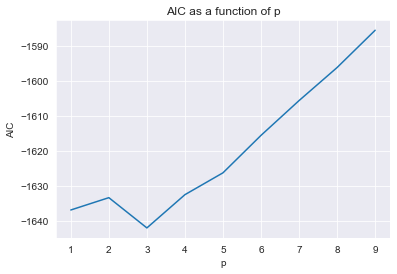

===== Optimization Report =====
* minimum value of the AIC : -1643.0
* p optimizing the AutoReg model : 3


In [ ]:
# Plotting the evolution of the criterion AIC as a function of p :
AIC_list = []
for p in range(1, 10):
    model = AutoReg(df['inf'], p, old_names=False)
    AIC_list.append(model.fit().aic)
x = range(1,10)
p_min = AIC_list.index(min(AIC_list)) + 1
AIC_min = AIC_list[p_min -1]

plt.plot(x, AIC_list)

plt.xlabel('p')
plt.ylabel('AIC')
plt.title('AIC as a function of p')

plt.show()
plt.close()

# Optimization report :
print('===== Optimization Report =====')
print(f'* minimum value of the AIC : {np.floor(AIC_min)}')
print(f'* p optimizing the AutoReg model : {p_min}')


We can now compute our optimized `AutoReg` model : 

In [ ]:
# Optimized model using p = 3 :
model = AutoReg(df['inf'], 3, old_names=False)
results_opt = model.fit()
print(results_opt.summary())

                            AutoReg Model Results                             
Dep. Variable:                    inf   No. Observations:                  212
Model:                     AutoReg(3)   Log Likelihood                 826.005
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Sun, 11 Dec 2022   AIC                          -1642.010
Time:                        08:44:01   BIC                          -1625.299
Sample:                             3   HQIC                         -1635.254
                                  212                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.578      0.010       0.000       0.003
inf.L1         0.5731      0.066      8.680      0.000       0.444       0.703
inf.L2        -0.0084      0.077     -0.109      0.9

### 6. Philips curve that explains the unemployment rate `Unemp` <a class="anchor" id="q6"></a> 

The Phillips curve is a statistical observation that illustrates a negative empirical relationship between the unemployment rate and inflation.

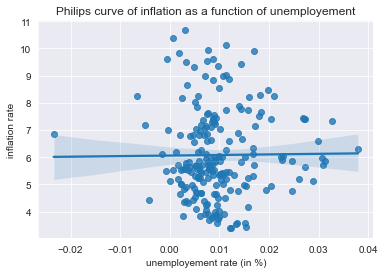

In [ ]:
# Plotting the Philips curve :
sns.regplot(x='inf', y='Unemp', data=df)

plt.ylabel('inflation rate')
plt.xlabel('unemployement rate (in %)')
plt.title('Philips curve of inflation as a function of unemployement')

plt.show()
plt.close()

### 7. Testing the Error autocorrelation <a class="anchor" id="q7"></a> 

We run an OLS regression on the variable `Unemp` using `inf` as the explanatory variable. To test the autocorrelation of the errors, we apply the Durbin Watson test on the residuals.

In [ ]:
# Dependant variable 
y = df['Unemp']

# Explicative variable
const = np.ones(np.shape(y))
inf = df['inf']
X = np.column_stack((const, inf))

# OLS  
model = sm.OLS(y, X)
results_unp = model.fit()

# performing the Durbin-Watson test :
dw_result = durbin_watson(results_unp.resid)
print('===== Durbin Watson test =====')
print(f'* DW test result : {dw_result}')


===== Durbin Watson test =====
* DW test result : 0.04424548742050977


The calculated value of the Durbin-Watson test is almost equal to $0$. For such a test, values less than $2.0$ mean that there is a positive autocorrelation. We can verify this statement by using autocorrelograms on our model (as we did in [question 3](#q3)):

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


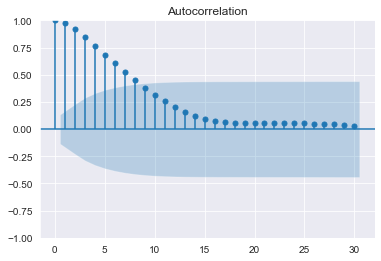

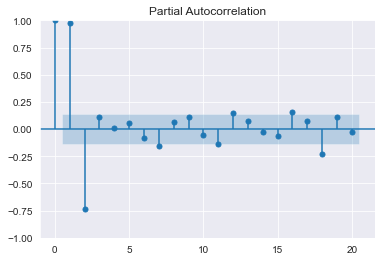

In [ ]:
# Autocorrelation of Unemp :
sm.graphics.tsa.plot_acf(df['Unemp'], lags=30);

# Partial autocorrelation of Unemp :
sm.graphics.tsa.plot_pacf(df['Unemp'], lags=20);

plt.show()
plt.close()

### 8. Error autocorrelation correction <a class="anchor" id="q8"></a> 

We consider the following model (In the following equations, $x$ and $y$ denote `inf` and `Unemp` respectively) : 
$$ y_{t-1} = \beta_0 + \beta_1x_{t-1} + u_{t-1}$$
$$ y_{t} = \beta_0 + \beta_1x_{t} + u_{t}$$
$$ u_t = \rho u_{t-1} + e_t $$
Subtracting the first equation from the second gives :
$$ y_{t} - \rho y_{t-1} = (1-\rho)\beta_0 + \beta_1(x_t - \rho x_{t-1}) + e_t $$
We first perform an OLS regression to determine $\rho$ :


In [ ]:
# OSL regression of the residuals : 
u = results_unp.resid
n = len(u)
u_1 = u[0:n-1]
const = np.ones(n-1)

X = np.column_stack((const, u_1))
y = u[1:n]

model = sm.OLS(y, X)
results_res = model.fit()

# Computing rho parameter :
rho = results_res.params[1]
print(f'rho : {rho}')

rho : 0.9798216453641824


We can now consider our new model using : 
$ y_{t} - \rho y_{t-1} \space\text{ and } x_{t} - \rho x_{t-1}\space $


In [ ]:
# Computing new variables :
inf, unemp = df['inf'], df['Unemp']
inf_1, unemp_1 = np.roll(inf, 1), np.roll(unemp, 1)
inf_1[0], unemp_1[0] = inf[0], unemp[0]

x_nm = inf - rho*inf_1
y_nm = unemp - rho*unemp_1
const = np.ones(np.shape(x_nm))
X_nm = np.column_stack((const, x_nm))

# Applying an OLS regression on our new model : 
model = sm.OLS(y_nm, X_nm)
results_nm = model.fit()

# performing the Durbin-Watson test
dw_result_nm = durbin_watson(results_nm.resid)
print('===== Durbin Watson test =====')
print(f'* DW test result : {dw_result_nm}')


===== Durbin Watson test =====
* DW test result : 0.7227233426848901


The Durbin Watson test is closer to $2$ (a value that indicates zero autocorrelation). We have slightly corrected the autocorrelation errors.

### 9. Test of the stability of the unemployment-inflation relationship <a class="anchor" id="q9"></a> 

We divide our dataset into two equal subsets (respectively `df_S1` and `df_S2`): 
* The first subset `S1` contains the data collected between `1960-Q1` and `1986-Q2`.
* The second subset `S2` contains the data collected between `1986-Q3` and `2012-Q4`.

In [ ]:
# Extracting the two subsets 
df_S1 = df.head(106)
df_S2 = df.tail(106).reset_index()

# Checking the sizes of the subsets
print('===== Report on the subsets =====')
print(f'* number of rows S1 : {df_S1.shape[0]}')
print(f'* number of rows S2 : {df_S2.shape[0]}')
print(f'* equal number of rows : {df_S1.shape[0] == df_S2.shape[0]}')

===== Report on the subsets =====
* number of rows S1 : 106
* number of rows S2 : 106
* equal number of rows : True


We run an OLS regression for each subset and check the estimated parameters :

In [ ]:
n1, n2 = len(df_S1['inf']), len(df_S2['inf'])

# OLS regression on S1 :
inf_S1, unemp_S1 = df_S1['inf'][1:], df_S1['Unemp'][1:]
inf_1_S1, unemp_1_S1 = np.roll(df_S1['inf'], 1)[1:], np.roll(df_S1['Unemp'], 1)[1:]

x_nm_S1, y_nm_S1 = inf_S1 - rho*inf_1_S1,  unemp_S1 - rho*unemp_1_S1
X_nm_S1 = np.column_stack((np.ones(n1 - 1), x_nm_S1))

model_S1 = sm.OLS(y_nm_S1, X_nm_S1)
results_S1 = model_S1.fit()
beta_S1 = results_S1.params

# OLS regression on S2 :
inf_S2, unemp_S2 = df_S2['inf'][1:], df_S2['Unemp'][1:]
inf_1_S2, unemp_1_S2 = np.roll(df_S2['inf'], 1)[1:], np.roll(df_S2['Unemp'], 1)[1:]

x_nm_S2, y_nm_S2 = inf_S2 - rho*inf_1_S2,  unemp_S2 - rho*unemp_1_S2
X_nm_S2 = np.column_stack((np.ones(n2 - 1), x_nm_S2))

model_S2 = sm.OLS(y_nm_S2, X_nm_S2)
results_S2 = model_S2.fit()
beta_S2 = results_S2.params

# Plotting results : 
print('===== Betas for each model =====')
print('* model subset S1 :')
print('-------------------')
print(beta_S1)
print('* model subset S2 :')
print('-------------------')
print(beta_S2)

===== Betas for each model =====
* model subset S1 :
-------------------
const     0.148158
x1      -26.245367
dtype: float64
* model subset S2 :
-------------------
const    0.129627
x1       0.538244
dtype: float64


Although the parameters obtained appear to be explicitly distinct, we will use Chow's test (structure change test) to test the following hypothesis: 

$$H_0 : \text{The coefficients of the two linear regressions on the different data sets S1 and S2 are equal.}$$

The Chow test formula is as follows :
$$ F_{\text{Chow}} = \frac{(\text{SSR}_{init} - (\text{SSR}_{S1}+\text{SSR}_{S2}))/k}{(\text{SSR}_{S1}+\text{SSR}_{S2})/(N_1 + N_2 - 2k)}$$
with, 
* $\text{SSR}_{init} :$ the residual sum of squares for the linear regression without breaks.
* $\text{SSR}_{Si} :$ the residual sum of squares for the linear regression lines represented by the data before and after the break point (here, `1986-Q2`).
* $N_i :$ the number of rows in the subset $Si$.
* $k :$ the number of breakpoints.


In [ ]:
# Utility function to compute SSR :
def comp_ssr(u): 
    ssr = 0
    for elt in u: 
        ssr+=(elt**2)
    return ssr

In [ ]:
# Computing F_chow :
N1, N2 = 106, 106
k = 2
q, ddl = k, N1 + N2 -2*k

SSR_init = comp_ssr(results_nm.resid)
SSR_S1 = comp_ssr(results_S1.resid)
SSR_S2 = comp_ssr(results_S2.resid)

F_chow = ((SSR_init - (SSR_S1 + SSR_S2))/k)/((SSR_S1 + SSR_S2)/(N1 + N2 - 2*k))
p_value = f.sf(F_chow, q, ddl)

# Plotting the results : 
print('===== Statistical Report =====')
print(f'* Chow\'s test value F_chow : {F_chow}')
print(f'* p-value : {p_value}')

===== Statistical Report =====
* Chow's test value F_chow : 4.496817205418956
* p-value : 0.012248967328644623


The p-value is below the $5\%$ threshold. We therefore reject the hypothesis $H_0$ for the separation that we have selected.

### 10. Estimation of the phillips curve <a class="anchor" id="q10"></a> 

We consider a new model : 
$$ \text{Unemp}_t = \beta_0 + \sum_{i=1}^4\beta_i \text{inf}_{t-i} + \sum_{j=1}^4\alpha_j \text{Unemp}_{t-j}$$
We will successively: 
* calculate the OLS regression of this new model. 
* do the Granger causality test of inflation on unemployment. 
* calculate the p-value.

Let us first compute the OLS regression.

In [ ]:
# OLS regression :
inf, unemp = df['inf'], df['Unemp']
n = len(inf)

# Computing the {1, 2, 3, 4} lags for 'inf' and 'Unemp' : 
inf_1, unemp_1 = np.roll(inf, 1)[4:], np.roll(unemp, 1)[4:]
inf_2, unemp_2 = np.roll(inf, 2)[4:], np.roll(unemp, 2)[4:]
inf_3, unemp_3 = np.roll(inf, 3)[4:], np.roll(unemp, 3)[4:]
inf_4, unemp_4 = np.roll(inf, 4)[4:], np.roll(unemp, 4)[4:]

const = np.ones(n-4)
X, y = np.column_stack((const, unemp_1, unemp_2, unemp_3, unemp_4, inf_1, inf_2, inf_3, inf_4)), unemp[4:]

model = sm.OLS(y, X)
results_phil = model.fit()

# Plotting the results :
print(results_phil.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1149.
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          4.60e-162
Time:                        09:09:47   Log-Likelihood:                 4.9681
No. Observations:                 208   AIC:                             8.064
Df Residuals:                     199   BIC:                             38.10
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1461      0.072      2.021      0.0

Based on the OLS summary, we can identify the significant variables in our new model. In this case, they are : $\text{inf}_{t-1}$ and $\text{inf}_{t-3}$.

Now let's do a Granger test. We test the hypothesis that none of the past values of $X$ can predict the value of $Y$.

In [ ]:
# Granger-Causality test :
grangercausalitytests(df[['Unemp', 'inf']], maxlag=[5])


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.7228  , p=0.0210  , df_denom=196, df_num=5
ssr based chi2 test:   chi2=14.3781 , p=0.0134  , df=5
likelihood ratio test: chi2=13.9007 , p=0.0163  , df=5
parameter F test:         F=2.7228  , p=0.0210  , df_denom=196, df_num=5


{5: ({'ssr_ftest': (2.7227999325322223, 0.02104450419735204, 196.0, 5),
   'ssr_chi2test': (14.37805066413699, 0.013378194758352353, 5),
   'lrtest': (13.900688236797578, 0.016252717156535597, 5),
   'params_ftest': (2.7227999325321717, 0.021044504197354128, 196.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

The p-values are below the $5\%$ threshold. We reject the hypothesis that inflation has no impact on unemployment.

### 11. Graphical representation of the distributed delays <a class="anchor" id="q11"></a> 

We consider a model containing distributed delays :
$$ \text{Unemp}_t = \beta_0 + \sum_{i=1}^4\beta_i \text{inf}_{t-i}$$

We will successively: 
* calculate the OLS regression of this new model. 
* plot a representation of the distributed delays.
* compute the long-term effect of those delays.

In [ ]:
# OLS regression :

const = np.ones(n-4)
inf_0 = inf[4:]
X, y = np.column_stack((const, inf_0, inf_1, inf_2, inf_3, inf_4)), unemp[4:]

model = sm.OLS(y, X)
results_dd = model.fit()

# Plotting the results :
print(results_dd.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.390
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           0.000814
Time:                        08:44:03   Log-Likelihood:                -385.15
No. Observations:                 208   AIC:                             782.3
Df Residuals:                     202   BIC:                             802.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7600      0.196     29.462      0.0

Plotting the distributed delays : 

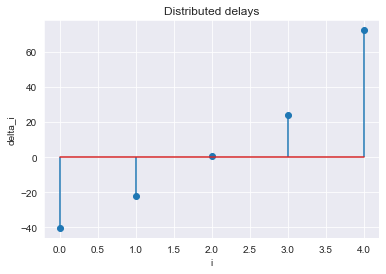

In [ ]:
# Graphical representation : 
dist_delays = results_dd.params[1:]
plt.stem([0,1,2,3,4],dist_delays.array)
plt.xlabel('i')
plt.ylabel('delta_i')
plt.title('Distributed delays')

plt.show()
plt.close()


The long-term effect `lt_eff` is given by :
$ \sum_{i=1}^4\beta_i $

In [ ]:
# Computing the long-term effect : 
lt_eff = dist_delays.sum()
print('===== Statistical Report =====')
print(f'* long-term effect : {lt_eff}')

===== Statistical Report =====
* long-term effect : 34.22604751739047
